# Dirichlet process for spatial clustering

Try and use the Dirichlet process to learn groupings of geographical regions.

In [1]:
import math
import copy
import random
import numpy as np
import scipy.special
import scipy.optimize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import matplotlib.cm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import pints
from sklearn.cluster import SpectralClustering

random.seed(123)
np.random.seed(123)

Create the test problem. Each american state has an unknown parameter $p \in [0, 1]$ which varies based on its location. The observed data at the state level, denoted $n$, consists of $N$ binomial trials where the probability of success is $p$.

In [2]:
# Get regions
regions_shapes = shpreader.natural_earth(
    resolution='110m',
    category='cultural',
    name='admin_1_states_provinces_lakes'
)
all_regions = list(shpreader.Reader(regions_shapes).geometries())

region_names = ['Minnesota',
                'Montana',
                'North Dakota',
                'Hawaii',
                'Idaho',
                'Washington',
                'Arizona',
                'California',
                'Colorado',
                'Nevada',
                'New Mexico',
                'Oregon',
                'Utah',
                'Wyoming',
                'Arkansas',
                'Iowa',
                'Kansas',
                'Missouri',
                'Nebraska',
                'Oklahoma',
                'South Dakota',
                'Louisiana',
                'Texas',
                'Connecticut',
                'Massachusetts',
                'New Hampshire',
                'Rhode Island',
                'Vermont',
                'Alabama',
                'Florida',
                'Georgia',
                'Mississippi',
                'South Carolina',
                'Illinois',
                'Indiana',
                'Kentucky',
                'North Carolina',
                'Ohio',
                'Tennessee',
                'Virginia',
                'Wisconsin',
                'West Virginia',
                'Delaware',
                'Washington DC',
                'Maryland',
                'New Jersey',
                'New York',
                'Pennsylvania',
                'Maine',
                'Michigan',
                'Alaska']


# Remove Alaska and Hawaii
regions_to_keep = [(name, region) for name, region in zip(region_names, all_regions) if name not in ('Alaska', 'Hawaii')]
all_regions = [x[1] for x in regions_to_keep]
region_names = [x[0] for x in regions_to_keep]


def distance_function(lat1, lon1, lat2, lon2):
    """Calculate distance between two geographical locations.
    
    Currently it is euclidean distance, but this can be replaced
    with great circle distance.
    """
    return ((lat1 - lat2)**2 + (lon1 - lon2)**2)**0.5


# Calculate p (unknown parameter) for each region
region_ps = []
for i, region in enumerate(all_regions):
    xy = region.centroid.xy
    lat = xy[1][0]
    lon = xy[0][0]
    dist = distance_function(lat, lon, 33.03405458467575, -96.90561836783115)
    region_ps.append(dist / 31)

# Sample n (observed data counts) for each region
N = 5
region_ns = []
for p in region_ps:
    if p <= 1:
        n = np.random.binomial(N, p)
    else:
        n = 0
    region_ns.append(n)
    
    
class Region:
    """
    Attributes
    ----------
    n : int
        observed counts in that region
    name : str
        Name of the region
    polygon : shapely polygon
        Polygon of the region
    truth : float, optional
        True value of the region's parameter (if known)
    """
    def __init__(self, n, name, polygon, truth=None):
        self.n = n
        self.name = name
        self.polygon = polygon
        self.truth = truth


# Make object for each reigon
region_objects = []
for region, name, n, p in zip(all_regions, region_names, region_ns, region_ps):
    region_objects.append(Region(n, name, region, p))

Plot the unknown parameter and the observed data for each state.

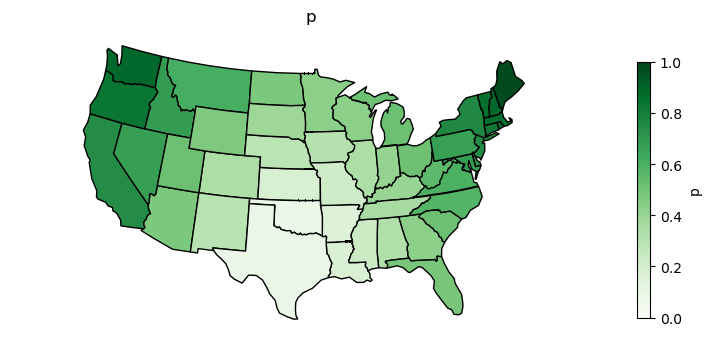

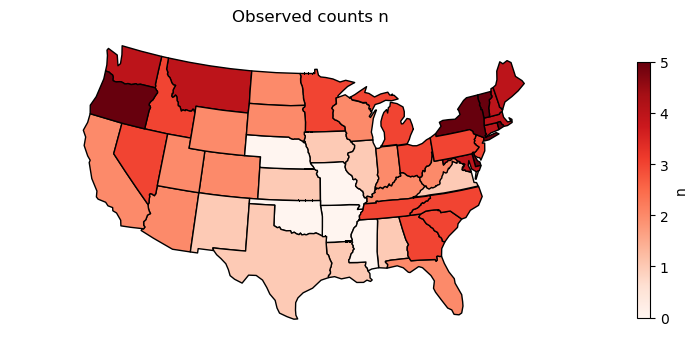

In [3]:
def plot_american_states(states, colors, hatches=None):
    fig = plt.figure()
    ax = fig.add_axes(
        [0, 0, 1, 1],
        projection=ccrs.LambertConformal(),
        frameon=False)
    ax.patch.set_visible(False)
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    
    if hatches is None:
        hatches = [None] * len(states)
    
    for color, state, hatch in zip(colors, states, hatches):
        ax.add_geometries(
            state.polygon,
            ccrs.PlateCarree(),
            facecolor=color,
            edgecolor='k',
            hatch=hatch
        )
    return fig, ax

    
# Plot p for each region
cmap = matplotlib.cm.get_cmap('Greens')    
fig, ax = plot_american_states(region_objects, [cmap(region.truth) for region in region_objects])
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, 1), cmap=cmap), ax=ax, fraction=0.02, pad=0.04, label='p')
ax.set_title('p')
plt.show()


# Plot n for each region
cmap = matplotlib.cm.get_cmap('Reds')    
fig, ax = plot_american_states(region_objects, [cmap(region.n/N) for region in region_objects])
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, N), cmap=cmap), ax=ax, fraction=0.02, pad=0.04, label='n')
ax.set_title('Observed counts n')
plt.show()

Model and inference implementation.

In [4]:
class RegionCluster:
    """A group of regions.
    
    Attributes
    ----------
    regions : list of Region
        The regions currently assigned to this cluster
        It can be empty. This would represent a new cluster.
    model : SumaliModel
        dirichlet process model object
    """
    def __init__(self, model):
        self.regions = []
        self.model = model
    
    def add_region(self, region):
        self.regions.append(region)
        region.cluster = self
    
    def remove_region(self, region):
        self.regions.remove(region)
        region.cluster = None
        
    def region_posterior(self, region):
        """Compute conditional posterior of region being assigned to this cluster.
        
        Parameters
        ----------
        region : Region
            The region whose probability of belonging to this cluster is being computed
            
        Returns
        -------
        float
            Log unnormalized
        """
        alpha = self.model.alpha
        n = self.model.n
        
        prior_a = self.model.prior_a
        prior_b = self.model.prior_b
        
        if len(self.regions) == 0:
            p1 = alpha / (n - 1 + alpha)
            p2 = math.log(scipy.special.binom(N, region.n)) + scipy.special.betaln(region.n + prior_a, N - region.n + prior_b) - scipy.special.betaln(prior_a, prior_b)
            
        else:
            p1 = len(self.regions) / (n - 1 + alpha)
            post_a = prior_a
            post_b = prior_b
            for region2 in self.regions:
                post_a += region2.n
                post_b += N - region2.n
            p2 = math.log(scipy.special.binom(N, region.n)) + scipy.special.betaln(region.n + post_a, N - region.n + post_b) - scipy.special.betaln(post_a, post_b)
    
        return p2 + math.log(p1) + self.distance_term(region)
    
    def param_posterior(self):
        """Get posterior of parameter value conditional on the regions assigned to this cluster.
        
        Returns
        -------
        scipy.stats.beta 
            distribution object
        """
        prior_a = self.model.prior_a
        prior_b = self.model.prior_b
        
        post_a = prior_a
        post_b = prior_b
        for region in self.regions:
            post_a += region.n
            post_b += N - region.n
            
        return scipy.stats.beta(post_a, post_b)
    
    def distance_term(self, region):
        """Distance between regions."""
        if len(self.regions) == 0:
            return 0
        
        potential = []

        xy = region.polygon.centroid.xy
        lat = xy[1][0]
        lon = xy[0][0]
        
        for region2 in self.regions:
            xy2 = region2.polygon.centroid.xy
            lat1 = xy2[1][0]
            lon1 = xy2[0][0]
            
            potential += [((lat - lat) ** 2 + (lon - lon1) **2)**0.5]
        
        potential = np.mean(potential)
        
        try:
            potential = 1/(0.1*potential**2)
        
        except ZeroDivisionError:
            potential = 0

        return math.log(potential)
    
    def is_connected(self):
        """Check if this cluster is connected, or it it has separate pieces.
        """
        if len(self.regions) == 0:
            return True
        
        remaining_region = self.regions[0].polygon
        for region2 in self.regions[1:]:
            remaining_region = remaining_region.union(region2.polygon)

        if remaining_region.geom_type == "MultiPolygon":
            return False

        elif remaining_region.geom_type == "Polygon":
            return True


def categorical_log(log_p):
    """Generate one sample from a categorical distribution with event
    probabilities provided in log-space.

    Parameters
    ----------
    log_p : array_like
        logarithms of event probabilities, which need not be normalized

    Returns
    -------
    int
        One sample from the categorical distribution, given as the index of that
        event from log_p.
    """
    exp_sample = math.log(random.random())
    events = np.logaddexp.accumulate(np.hstack([[-np.inf], log_p]))
    events -= events[-1]
    sample = next(x[0]-1 for x in enumerate(events) if x[1] >= exp_sample)
    return sample


class SumaliModel:
    """Dirichlet process based clustering of regions.
    """
    def __init__(self,
                 regions,
                 alpha=0.1,
                 mcmc_init="together",
                 connected=True):
        """
        regions : list of Region
            All regions to be assigned to clusters
        alpha : float
            Dp concentration parameter (currently fixed)
        mcmc_init : {"together", "separate"}
            Whether to start MCMC chain with all regions in one cluster (together)
            or all in their own cluster (separate)
        connected : bool
            Whether to require that clusters are connected
        """
        self.alpha = alpha
        self.regions = copy.deepcopy(regions)
            
        self.n = len(self.regions)
            
        if mcmc_init == "together":
            self.clusters = [RegionCluster(self)]
            for region in self.regions:
                self.clusters[-1].add_region(region)
        elif mcmc_init == "separate":
            self.clusters = []
            for region in self.regions:
                cluster = RegionCluster(self)
                cluster.add_region(region)
                self.clusters.append(cluster)
            
        self.parameters = {}
        for region in self.regions:
            self.parameters[region.name] = []
            
        self.connected = connected
        
        self.prior_a = 1
        self.prior_b = 1

    def update_local_params(self):
        """Update the parameter values conditional on the current assignments.
        """
        for cluster in self.clusters:
            post = cluster.param_posterior()
            x = post.rvs()
            for region in cluster.regions:
                self.parameters[region.name].append(x)
        
    def gibbs_step(self):
        """Gibbs update for cluster assignments.
        """
        for region in self.regions:
            # Remove the region from its current cluster
            current_cluster = region.cluster
            current_cluster.remove_region(region)
            
            # If it was the only member of that cluster, its now empty so remove it
            if len(current_cluster.regions) == 0:
                self.clusters.remove(current_cluster)
    
            else:
                if self.connected:
                    # Check if removing this region from its cluster causes that region to no longer
                    # be connected.
                    # If so, assume that conditional probability of being assigned to any other cluster is 
                    # zero, so put the region back in the cluster and move on.
                    if not current_cluster.is_connected():
                        current_cluster.add_region(region)
                        continue
            
            # Compute conditional posterior of being in each existing cluster
            cluster_probs = []
            for cluster in self.clusters:
                cluster_probs.append(cluster.region_posterior(region))
                
                if self.connected:
                    # Require that the region is in contact with the cluster. If its not,
                    # set the log posterior to minus infinity
                    touch = False
                    for region2 in cluster.regions:
                        if region2.polygon.touches(region.polygon):
                            touch = True
                            break
                            
                    if not touch:
                        cluster_probs[-1] += -math.inf
                    
            # Compute conditional posterior of being in a new cluster
            new_cluster = RegionCluster(self)
            cluster_probs.append(new_cluster.region_posterior(region))
            
            # Sample the new cluster assignment
            cluster_probs = np.asarray(cluster_probs)
            assigned_cluster_idx = categorical_log(cluster_probs)
            assigned_cluster = (self.clusters + [new_cluster])[assigned_cluster_idx]
            
            # Add region to its updated cluster
            assigned_cluster.add_region(region)
            if assigned_cluster == new_cluster:
                self.clusters.append(assigned_cluster)
                
    def compute_assignments(self):
        assigns = [-1] * len(self.regions)
        for j, cluster in enumerate(self.clusters):
            for region in cluster.regions:
                assigns[self.regions.index(region)] = j
        self.assigns = assigns
            
    def run_mcmc_step(self, progress=False):
        """Run one MCMC step to generate samples from the posterior.
        """
        self.gibbs_step()
        self.compute_assignments()
        self.update_local_params()
        

def run_inference(*models, num_mcmc_iter=10):
    params_chain = []
    assign_chain = []
    num_clusters_chain = []
    
    for i in range(num_mcmc_iter):
        params_chain.append([])
        assign_chain.append([])
        num_clusters_chain.append([])

        for model in models:
            model.run_mcmc_step()

            params_chain[-1].append(copy.deepcopy(model.parameters))
            assign_chain[-1].append(copy.deepcopy(model.assigns))
            num_clusters_chain[-1].append(len(set(model.clusters)))
            
        if i > 5 and i % 100 == 0:
            rhat = pints.rhat(np.asarray(num_clusters_chain).T[:, i//2:])
            print('Iter={}, Rhat={}'.format(i, rhat))
            
    return params_chain, assign_chain, num_clusters_chain

Run inference with two MCMC chains.

In [5]:
# region_objects = sorted(region_objects, key=lambda x: x.truth)

m1 = SumaliModel(
    region_objects,
    alpha=1,
    mcmc_init="together",
    connected=True
)

m2 = SumaliModel(
    region_objects,
    alpha=1,
    mcmc_init="separate",
    connected=True
)

params_chain, assign_chain, num_clusters_chain = run_inference(m1, m2, num_mcmc_iter=2001)

Iter=100, Rhat=1.7485913013212828
Iter=200, Rhat=1.044356946979709
Iter=300, Rhat=1.0222263144375674
Iter=400, Rhat=1.0063310239444248
Iter=500, Rhat=1.0061894185978957
Iter=600, Rhat=0.9971257160196767
Iter=700, Rhat=1.0063733560647579
Iter=800, Rhat=1.013790386254477
Iter=900, Rhat=1.007795838418106
Iter=1000, Rhat=1.00358465838312
Iter=1100, Rhat=0.9999905426475336
Iter=1200, Rhat=1.015851589878315
Iter=1300, Rhat=1.01570971353145
Iter=1400, Rhat=0.9986692253468524
Iter=1500, Rhat=1.0019029668502197
Iter=1600, Rhat=1.005096121527713
Iter=1700, Rhat=1.0072303994647442
Iter=1800, Rhat=1.003224085386327
Iter=1900, Rhat=0.9995295515756336
Iter=2000, Rhat=1.0019573448020762


The inference algorithm yields a set of MCMC samples of clustering configurations which reflect a posterior distribution over possible clusterings. However, we would like to extract a single clustering configuration from this distribution for further analysis. We propose the following algorithm to obtain this.

1. Get the mode number of clusters from the MCMC chains.
2. Compute a affinity matrix between each fine scale region. The affinity between any two regions is the number of iterations in the MCMC chain where those two regions were in the same cluster.
4. Use an off-the-shelf clustering algorithm to develop clusters based on those affinities. Ideas: Agglomerative hierarchical clustering. Spectral clustering.

In [6]:
def compute_connectivity_matrix(assign_chain):
    connectivity = np.zeros((len(region_objects), len(region_objects)))

    for model_assignments in assign_chain[len(assign_chain)//2:]:
        for assignments in model_assignments:
            for i, cluster_i in enumerate(assignments):
                for j, cluster_j in enumerate(assignments):
                    if i != j and cluster_i == cluster_j:
                        connectivity[i, j] += 1
                    if i == j:
                        connectivity[i, j] += 1
    return connectivity

    
def consensus_clustering(num_clusters_chain, assign_chain):
    num_clusters_samples = num_clusters_chain[len(num_clusters_chain)//2:]
    num_clusters_samples = [x for sublist in num_clusters_samples for x in sublist]
    num_clusters = scipy.stats.mode(num_clusters_samples)[0]
    
    connectivity = compute_connectivity_matrix(assign_chain)
    
    m = SpectralClustering(n_clusters=num_clusters, affinity='precomputed').fit(connectivity)
    
    return num_clusters, m.labels_

#     connectivity = np.max(connectivity) - connectivity
#     condensed_distances = scipy.spatial.distance.squareform(connectivity)
#     clustering = scipy.cluster.hierarchy.linkage(condensed_distances, method='single')
#     clusters = scipy.cluster.hierarchy.fcluster(clustering, num_clusters, 'maxclust')
    
#     return num_clusters, clusters


def plot_connect_matrix(matrix, regions):    
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(matrix, cmap=matplotlib.cm.get_cmap('Greys'))

    ax.set_yticks(range(len(regions)))
    ax.set_yticklabels([r.name for r in regions])

    ax.set_xticks(range(len(regions)))
    ax.set_xticklabels([r.name for r in regions], rotation=90)

    fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, np.max(matrix)), cmap=matplotlib.cm.get_cmap('Greys')), ax=ax, fraction=0.02, pad=0.04, label='Num mcmc iterations co-clustering')
    return fig

We also obtain the parameter inference with and without clustering.

In [7]:
def plot_posteriors(region_objects, params_chain, model):
    region_objects = sorted(region_objects, key=lambda x: x.truth)

    clustering_results = []

    for region in region_objects:
        chains = params_chain[-1]
        samples = []
        for chain in chains:
            samples += chain[region.name][len(chain[region.name])//2:]

        x = {
            'label': region.name,
            'whislo': np.percentile(samples, 5),
            'q1': np.percentile(samples, 25),
            'med': np.percentile(samples, 50),
            'q3': np.percentile(samples, 75),
            'whishi': np.percentile(samples, 95),
            'fliers': []
        }  

        clustering_results.append(x)

    nonclustering_results = []
    for region in region_objects:
        newclut = RegionCluster(model)
        newclut.add_region(copy.deepcopy(region))
        p_post = newclut.param_posterior()
        i1 = p_post.interval(0.90)
        i2 = p_post.interval(0.5)
        med = p_post.median()

        x = {
            'label': region.name,
            'whislo': i1[0],
            'q1': i2[0],
            'med': med,
            'q3': i2[1] ,
            'whishi': i1[1],
            'fliers': []
        }
        nonclustering_results.append(x)

    truths = [region.truth for region in region_objects]

    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.bxp(clustering_results, showfliers=False, positions=np.arange(1, len(truths)+1), widths=0.15)
    ax.plot(range(1, len(truths)+1), truths, color='k', ls='--')
    plt.xticks(rotation=90)
    ax.set_title('With clustering')

    ax = fig.add_subplot(1, 2, 2, sharey=ax)
    ax.bxp(nonclustering_results, showfliers=False, positions=np.arange(1, len(truths)+1)+0.2, widths=0.15)
    ax.plot(range(1, len(truths)+1), truths, color='k', ls='--')
    plt.xticks(rotation=90)
    ax.set_title('Without clustering')
    return fig

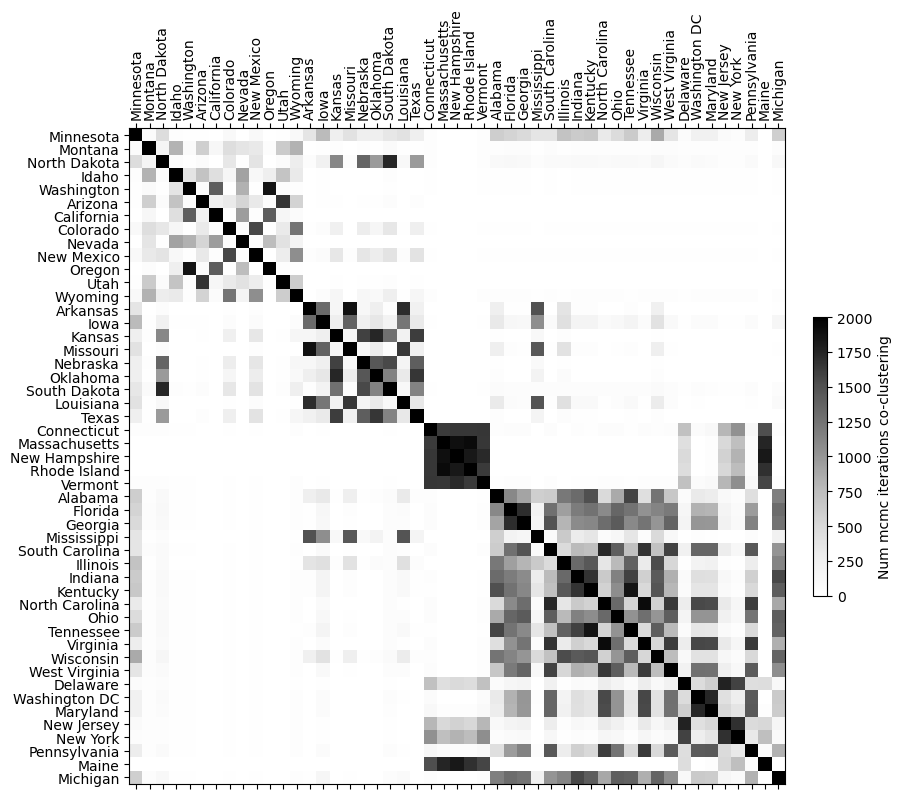

In [8]:
matrix = compute_connectivity_matrix(assign_chain)
plot_connect_matrix(matrix, region_objects)
plt.show()

C:\Users\Richard\.conda\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


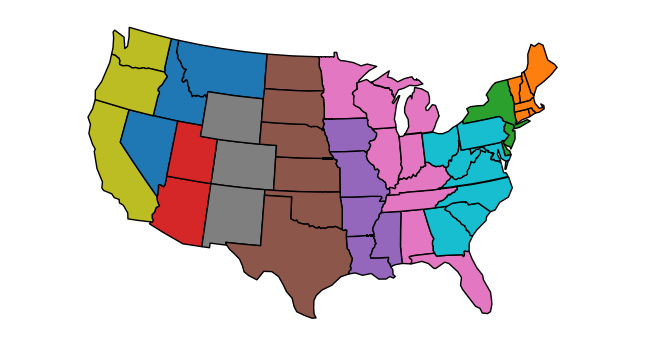

In [9]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color'][::-1]

n, clusters = consensus_clustering(num_clusters_chain, assign_chain)
cluster_colors = [colors[i % len(colors)] for i in clusters]

lines = [None, '//', '\\']
cluster_lines = [lines[i // len(colors)] for i in clusters]

fig, ax = plot_american_states(region_objects, cluster_colors, cluster_lines)
plt.show()

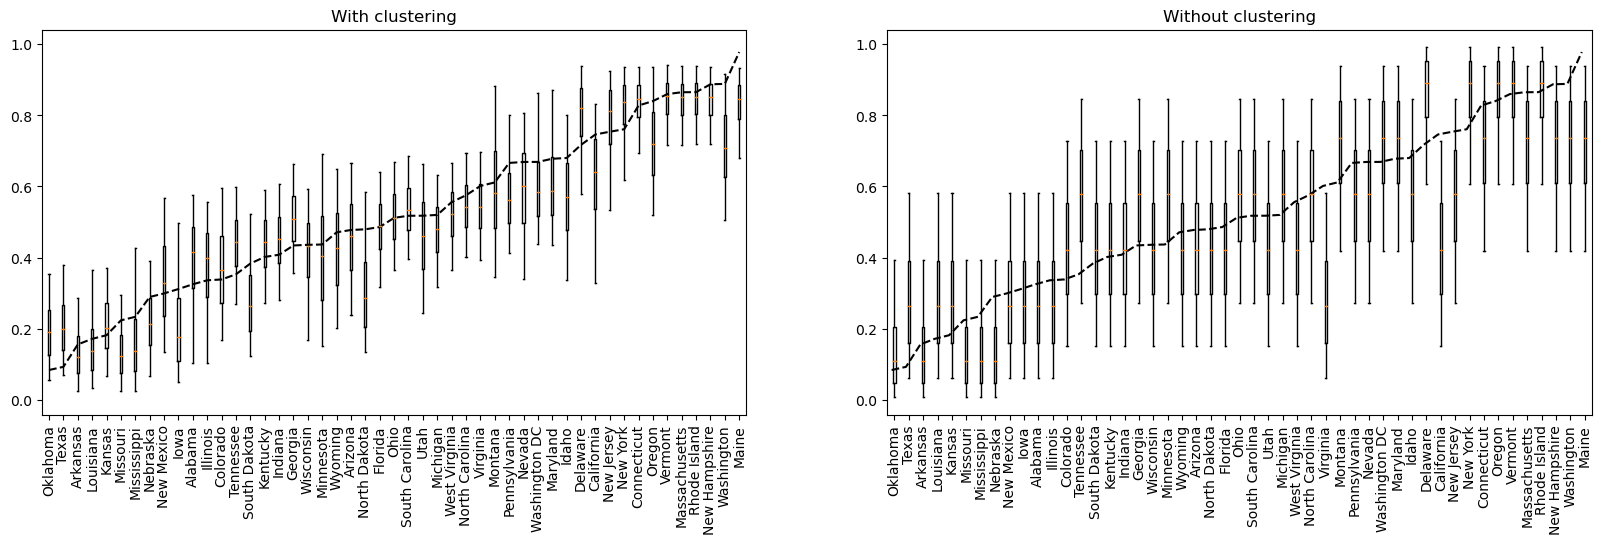

In [10]:
fig = plot_posteriors(region_objects, params_chain, m1)
plt.show()

Repeat the method without requiring that clusters be connected.

In [11]:
m1 = SumaliModel(
    region_objects,
    alpha=0.5,
    mcmc_init="together",
    connected=False
)

m2 = SumaliModel(
    region_objects,
    alpha=0.5,
    mcmc_init="separate",
    connected=False
)

params_chain, assign_chain, num_clusters_chain = run_inference(m1, m2, num_mcmc_iter=2001)

Iter=100, Rhat=1.0039597714410995
Iter=200, Rhat=1.0313707287273206
Iter=300, Rhat=1.0607259644146738
Iter=400, Rhat=1.047113531390759
Iter=500, Rhat=1.0085904556286107
Iter=600, Rhat=0.997695722802153
Iter=700, Rhat=1.0043131244009293
Iter=800, Rhat=1.0194062319273243
Iter=900, Rhat=1.0031354566144672
Iter=1000, Rhat=0.9984891081119015
Iter=1100, Rhat=1.0124878877284835
Iter=1200, Rhat=1.0189179204231131
Iter=1300, Rhat=1.0056690966205515
Iter=1400, Rhat=1.0012567139719002
Iter=1500, Rhat=1.0000618859378934
Iter=1600, Rhat=0.999717795759253
Iter=1700, Rhat=1.0017324817288626
Iter=1800, Rhat=1.001205113147301
Iter=1900, Rhat=1.0045349043683534
Iter=2000, Rhat=1.0033124316932909


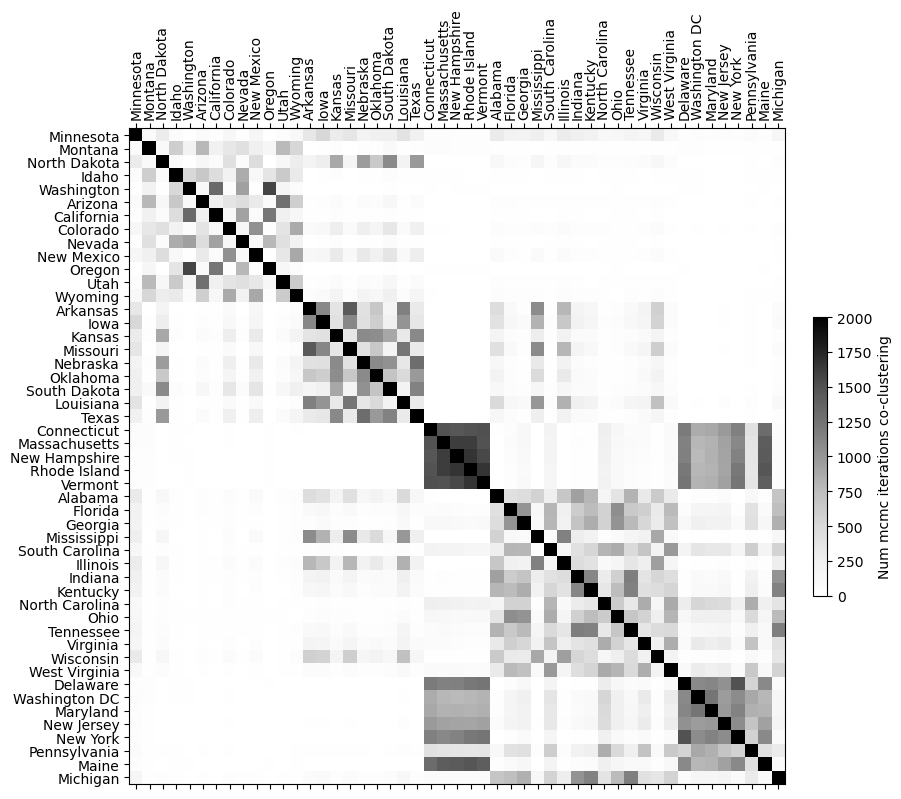

In [12]:
matrix = compute_connectivity_matrix(assign_chain)
plot_connect_matrix(matrix, region_objects)
plt.show()

C:\Users\Richard\.conda\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


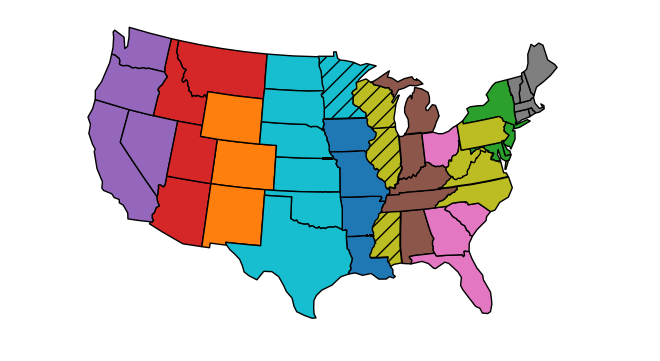

In [13]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color'][::-1]

n, clusters = consensus_clustering(num_clusters_chain, assign_chain)
cluster_colors = [colors[i % len(colors)] for i in clusters]

lines = [None, '//', '\\']
cluster_lines = [lines[i // len(colors)] for i in clusters]

fig, ax = plot_american_states(region_objects, cluster_colors, cluster_lines)
plt.show()

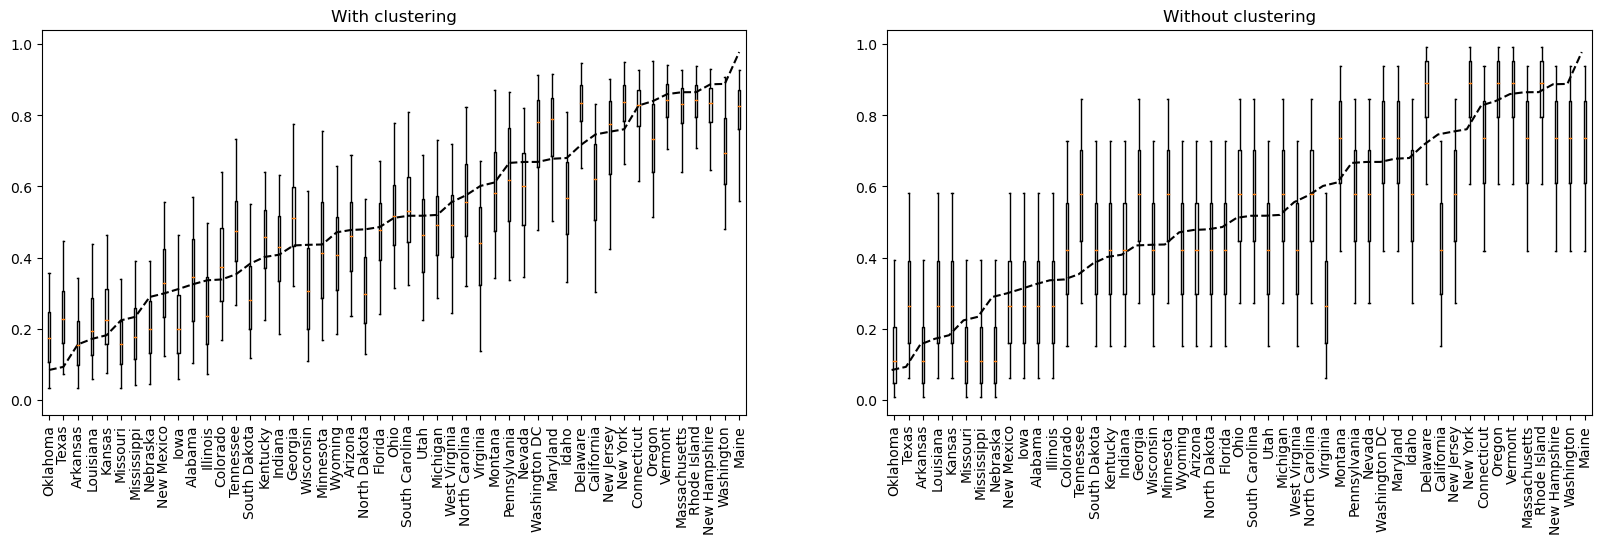

In [14]:
fig = plot_posteriors(region_objects, params_chain, m1)
plt.show()

In [15]:
m1 = SumaliModel(
    region_objects,
    alpha=0.1,
    mcmc_init="together",
    connected=False
)

m2 = SumaliModel(
    region_objects,
    alpha=0.1,
    mcmc_init="separate",
    connected=False
)

params_chain, assign_chain, num_clusters_chain = run_inference(m1, m2, num_mcmc_iter=2001)

Iter=100, Rhat=1.02449753655087
Iter=200, Rhat=1.0495494261164982
Iter=300, Rhat=1.0065865632587636
Iter=400, Rhat=1.0132509944438286
Iter=500, Rhat=1.0229437067740754
Iter=600, Rhat=1.0234342497785318
Iter=700, Rhat=1.0115106641523295
Iter=800, Rhat=1.0153819039452747
Iter=900, Rhat=1.0091118886281252
Iter=1000, Rhat=1.015356453627711
Iter=1100, Rhat=1.001245863469338
Iter=1200, Rhat=0.9983598178514566
Iter=1300, Rhat=1.0028914980396686
Iter=1400, Rhat=1.0118639199801587
Iter=1500, Rhat=1.002637016241192
Iter=1600, Rhat=0.9991123560014461
Iter=1700, Rhat=0.999385284654483
Iter=1800, Rhat=1.000284309755197
Iter=1900, Rhat=1.0031736871017198
Iter=2000, Rhat=1.002815616739246


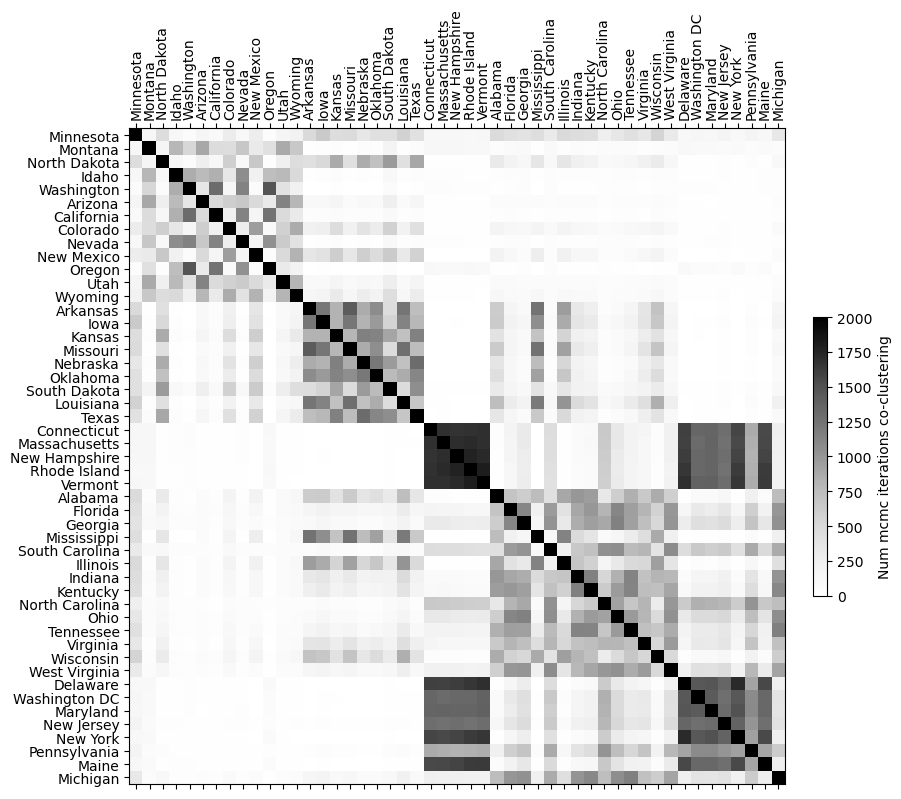

In [16]:
matrix = compute_connectivity_matrix(assign_chain)
plot_connect_matrix(matrix, region_objects)
plt.show()

C:\Users\Richard\.conda\envs\py310\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


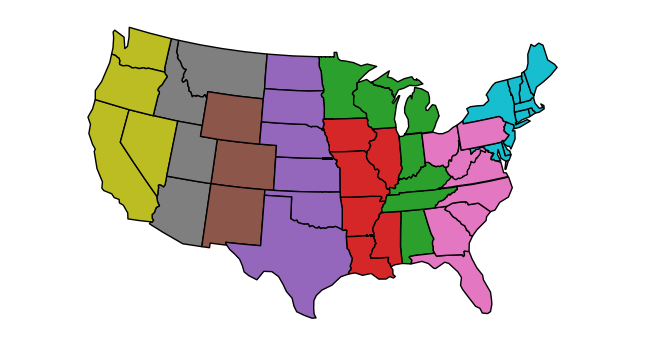

In [17]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color'][::-1]

n, clusters = consensus_clustering(num_clusters_chain, assign_chain)
cluster_colors = [colors[i % len(colors)] for i in clusters]

lines = [None, '//', '\\']
cluster_lines = [lines[i // len(colors)] for i in clusters]

fig, ax = plot_american_states(region_objects, cluster_colors, cluster_lines)
plt.show()

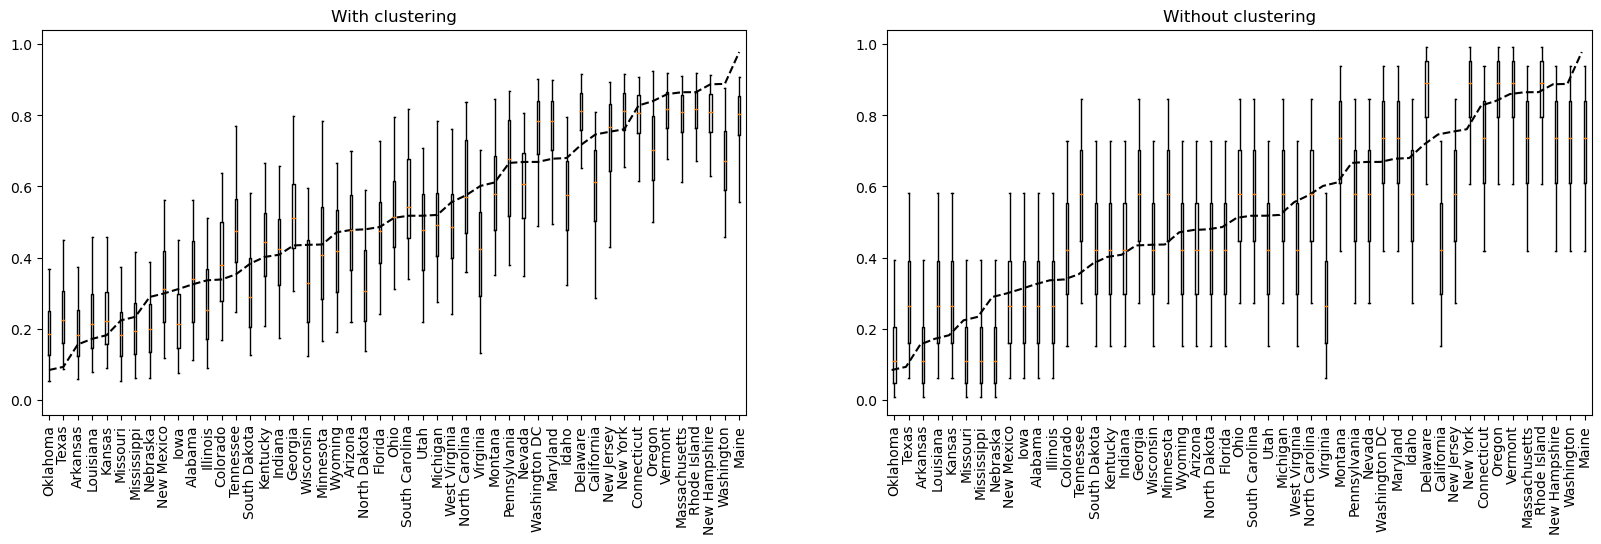

In [18]:
fig = plot_posteriors(region_objects, params_chain, m1)
plt.show()

The obtained clusters are highly dependent on the assumptions made about the concentration parameter and the distance term.

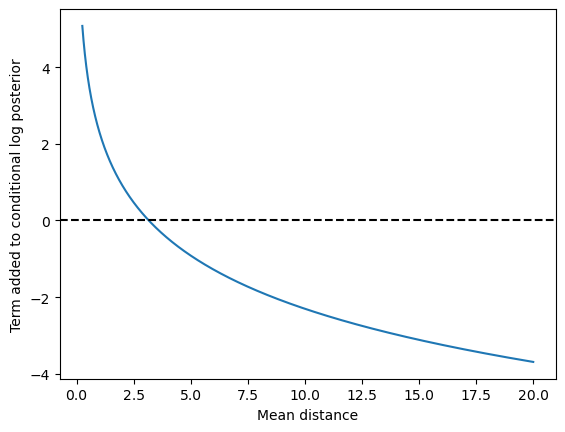

In [19]:
dists = np.arange(0.25, 20, 0.0001)
terms = np.log(1 / (0.1 * dists**2))
    
plt.plot(dists, terms)
plt.axhline(0, color='k', ls='--')
plt.xlabel('Mean distance')
plt.ylabel('Term added to conditional log posterior')
plt.show()